# World Happiness Report, Checkpoint 2

## Data Preprocessing

### Imports

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Parsing and Organizing

First, we load in each DataFrame and check their shapes and columns.

In [97]:
df_2015 = pd.read_csv('2015.csv')
df_2016 = pd.read_csv('2016.csv')
df_2017 = pd.read_csv('2017.csv')
df_2018 = pd.read_csv('2018.csv')
df_2019 = pd.read_csv('2019.csv')

df_years = [(df_2015, 2015), (df_2016, 2016), (df_2017, 2017), (df_2018, 2018), (df_2019, 2019)]

# Check the shape and columns of each DataFrame
for df, year in df_years:
    print(f"DataFrame for {year}:")
    print(df.shape)
    print(df.columns)

DataFrame for 2015:
(158, 12)
Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Standard Error', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual'],
      dtype='object')
DataFrame for 2016:
(157, 13)
Index(['Country', 'Region', 'Happiness Rank', 'Happiness Score',
       'Lower Confidence Interval', 'Upper Confidence Interval',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Dystopia Residual'],
      dtype='object')
DataFrame for 2017:
(155, 12)
Index(['Country', 'Happiness.Rank', 'Happiness.Score', 'Whisker.high',
       'Whisker.low', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual'],
      dtype='object')
DataFrame for 2018:
(156, 9)
Index(['Overall

We see that the columns are not consistent across each DataFrame, so we need to standardize the columns across the years.

In [98]:
new_columns = ['Country', 'Region', 'Happiness_Score', 'GDP_per_Capita',
               'Social_Support', 'Healthy_Life_Expectancy', 'Freedom',
               'Perceptions_of_Corruption', 'Generosity', 'Year']

new_columns_missing_region = ['Country', 'Happiness_Score', 'GDP_per_Capita', 
                        'Social_Support', 'Healthy_Life_Expectancy', 'Freedom', 
                        'Perceptions_of_Corruption', 'Generosity', 'Year', 'Region']

# 2015
df_2015_clean = df_2015[['Country', 'Region', 'Happiness Score', 
                        'Economy (GDP per Capita)', 'Family', 
                        'Health (Life Expectancy)', 'Freedom', 
                        'Trust (Government Corruption)', 'Generosity']].copy()
df_2015_clean['Year'] = 2015
df_2015_clean.columns = new_columns

# 2016
df_2016_clean = df_2016[['Country', 'Region', 'Happiness Score', 
                        'Economy (GDP per Capita)', 'Family', 
                        'Health (Life Expectancy)', 'Freedom', 
                        'Trust (Government Corruption)', 'Generosity']].copy()
df_2016_clean['Year'] = 2016
df_2016_clean.columns = new_columns

# 2017
df_2017_clean = df_2017[['Country', 'Happiness.Score', 
                        'Economy..GDP.per.Capita.', 'Family', 
                        'Health..Life.Expectancy.', 'Freedom', 
                        'Trust..Government.Corruption.', 'Generosity']].copy()
df_2017_clean['Year'] = 2017
df_2017_clean['Region'] = pd.NA  # Missing in 2017 dataset
df_2017_clean.columns = new_columns_missing_region

# 2018
df_2018_clean = df_2018[['Country or region', 'Score', 
                        'GDP per capita', 'Social support', 
                        'Healthy life expectancy', 'Freedom to make life choices', 
                        'Generosity', 'Perceptions of corruption']].copy()
df_2018_clean['Year'] = 2018
df_2018_clean['Region'] = pd.NA  # Missing in 2018 dataset
df_2018_clean.columns = new_columns_missing_region

# 2019
df_2019_clean = df_2019[['Country or region', 'Score', 
                        'GDP per capita', 'Social support', 
                        'Healthy life expectancy', 'Freedom to make life choices', 
                        'Generosity', 'Perceptions of corruption']].copy()
df_2019_clean['Year'] = 2019
df_2019_clean['Region'] = pd.NA  # Missing in 2019 dataset
df_2019_clean.columns = new_columns_missing_region

# Combine all datasets
happiness_df = pd.concat([df_2015_clean, df_2016_clean, df_2017_clean, 
                        df_2018_clean, df_2019_clean], ignore_index=True)

# Fill missing regions by looking up countries in other years
for country in happiness_df[happiness_df['Region'].isna()]['Country'].unique():
    region = happiness_df[(happiness_df['Country'] == country) & 
                         (happiness_df['Region'].notna())]['Region'].unique()
    if len(region) > 0:
        happiness_df.loc[(happiness_df['Country'] == country) & 
                        (happiness_df['Region'].isna()), 'Region'] = region[0]

# Check for duplicates
print("Duplicates:", happiness_df.duplicated().sum())

# Check for missing values
happiness_df.isna().sum()

Duplicates: 0


Country                      0
Region                       8
Happiness_Score              0
GDP_per_Capita               0
Social_Support               0
Healthy_Life_Expectancy      0
Freedom                      0
Perceptions_of_Corruption    0
Generosity                   1
Year                         0
dtype: int64

We see that eight countries are still missing regions, and one country is missing generosity. As a result, we will first identify the missing values, and attempt to fill them in manually.

In [99]:
# Look at the available regions to fill in for missing values later
unique_regions = happiness_df['Region'].unique()
print(unique_regions.tolist())

missing_values = happiness_df[happiness_df.isna().any(axis=1)]
missing_values[['Country', 'Region', 'Generosity', 'Year']]

['Western Europe', 'North America', 'Australia and New Zealand', 'Middle East and Northern Africa', 'Latin America and Caribbean', 'Southeastern Asia', 'Central and Eastern Europe', 'Eastern Asia', 'Sub-Saharan Africa', 'Southern Asia', nan]


,Country,Region,Generosity,Year
347,Taiwan Province of China,NaN,0.258360,2017
385,"Hong Kong S.A.R., China",NaN,0.374466,2017
489,United Arab Emirates,Middle East and Northern Africa,NaN,2018
507,Trinidad & Tobago,NaN,0.019000,2018
527,Northern Cyprus,NaN,0.154000,2018
664,Trinidad & Tobago,NaN,0.016000,2019
689,Northern Cyprus,NaN,0.162000,2019
709,North Macedonia,NaN,0.034000,2019
745,Gambia,NaN,0.167000,2019


Now that we have identified the missing values, we can manually assign the regions, and for the United Arab Emirates' generosity for 2018, we can use the median generosity based on its region's generosity for 2018.

In [100]:
# Fill in missing regions
happiness_df.loc[
    (happiness_df['Country'] == 'Taiwan Province of China') &
    (happiness_df['Year'] == 2017), 'Region'
] = 'Eastern Asia'

happiness_df.loc[
    (happiness_df['Country'] == 'Hong Kong S.A.R., China') &
    (happiness_df['Year'] == 2017), 'Region'
] = 'Eastern Asia'

happiness_df.loc[
    (happiness_df['Country'] == 'Trinidad & Tobago') &
    (happiness_df['Year'] == 2018), 'Region'
] = 'Latin America and Caribbean'

happiness_df.loc[
    (happiness_df['Country'] == 'Northern Cyprus') &
    (happiness_df['Year'] == 2018), 'Region'
] = 'Middle East and Northern Africa'

happiness_df.loc[
    (happiness_df['Country'] == 'Trinidad & Tobago') &
    (happiness_df['Year'] == 2019), 'Region'
] = 'Latin America and Caribbean'

happiness_df.loc[
    (happiness_df['Country'] == 'Northern Cyprus') &
    (happiness_df['Year'] == 2019), 'Region'
] = 'Middle East and Northern Africa'

happiness_df.loc[
    (happiness_df['Country'] == 'North Macedonia') &
    (happiness_df['Year'] == 2019), 'Region'
] = 'Central and Eastern Europe'

happiness_df.loc[
    (happiness_df['Country'] == 'Gambia') &
    (happiness_df['Year'] == 2019), 'Region'
] = 'Sub-Saharan Africa'

# Fill in missing generosity with median
median_generosity = happiness_df.groupby(['Region', 'Year'])['Generosity'].median()
happiness_df.loc[
    (happiness_df['Country'] == 'United Arab Emirates') &
    (happiness_df['Year'] == 2018), 'Generosity'
] = median_generosity.loc['Middle East and Northern Africa', 2018]

# Check for missing values again
happiness_df.isna().sum()

Country                      0
Region                       0
Happiness_Score              0
GDP_per_Capita               0
Social_Support               0
Healthy_Life_Expectancy      0
Freedom                      0
Perceptions_of_Corruption    0
Generosity                   0
Year                         0
dtype: int64

## Basic Data Exploration and Summary Statistics

### First Hypothesis

Assume $\alpha = 0.05$.<br>
HO: The GDP per capita does not have an effect on happiness score.<br>
HA: The GDP per capita does have an effect on happiness score.

A visualization of the hypothesis.

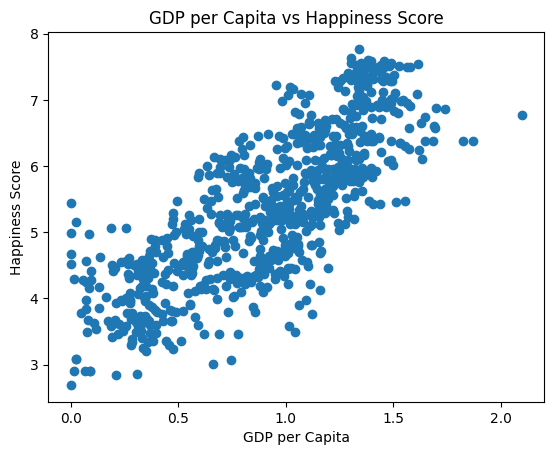

In [101]:
plt.scatter(happiness_df['GDP_per_Capita'], happiness_df['Happiness_Score'])
plt.xlabel('GDP per Capita')
plt.ylabel('Happiness Score')
plt.title('GDP per Capita vs Happiness Score')
plt.show()


We will use Pearson's correlation coefficient for this hypothesis test because we are dealing with continuous variables, and our previous scatter plot suggests that there is a linear relationship.

In [93]:
result = pearsonr(happiness_df['GDP_per_Capita'], happiness_df['Happiness_Score'])
print(result.pvalue)

2.2137878354296676e-167


Since the p-value is less than our significance level of 0.05, we reject the null hypothesis, concluding that the GDP per capita does have an effect on happiness score.